### Import modules and packages. define functions

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
import pims
from scipy import stats

%matplotlib inline

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r

plt.rcParams.update({'font.size': 22})

### Specify experiment directory, condtions and image details
#### Makes dictionary for Protein2r storage of results

In [89]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180411and0412_LTPStim_Cy3laserto25percent/' #master folder

Protein1_channel_no=1 
Protein2_channel_no=2


results = {"filename":[],
           "Slice_id":[],
           "Protein1 colour - spots mask":[],
           "Protein2 colour - spots mask":[],
           "exp condition":[],
           "Protein1 colour - Raw mean intensity":[],
           "Protein2 colour - Raw mean intensity":[],
           "Mean correlation coefficient Protein1/Protein2":[],
           "Protein1 colour - Mean intensity of spots":[], #based on spot segmentation mask
           "Protein2 colour - Mean intensity of spots":[], #based on spot segmentation mask
           "Protein1 colour - Total no. of spots in FOV":[],
           "Protein2 colour - Total no. of spots in FOV":[],
           "Protein1 colour - Mean spot area [nm]":[],
           "Protein2 colour - Mean spot area [nm]":[],
           "Mean colour bias of a pixel (Protein1=-1<x<1=Protein2)":[],
           "Protein1 colour - Mean intensity, masked by Protein2 spots":[],
           "Protein1 colour - Mean intensity, outside of Protein2 spots":[]}

path = os.path.dirname(expdir)
print(path)
#outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))
        
print(filelist)

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180411and0412_LTPStim_Cy3laserto25percent
['/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180411and0412_LTPStim_Cy3laserto25percent/.DS_Store', '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180411and0412_LTPStim_Cy3laserto25percent/._.DS_Store', '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180411and0412_LTPStim_Cy3laserto25percent/DMSO/20180411_13_LFS_bad.lif', '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180411and0412_LTPStim_Cy3laserto25percent/DMSO/20180411_14_LFS.lif', '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180411and0412_LTPStim_Cy3laserto25percent/DMSO/20180411_15_HFS.lif', '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180411and0412_LTPStim_Cy3laserto25percent/DMSO/20180411_16_LFS.lif', '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180411and0412_LTPStim_Cy3laserto

In [ ]:
#run this to name the conditions after the containing folder names
for i in range(0,len(filelist)):
    if filelist[i].endswith(".tif") & ("60x" in str(filelist[i]))==True & (os.stat(filelist[i]).st_size<1048576)==True:
        results["filename"].append(filelist[i])
        results["exp condition"].append(filelist[i].split('/')[-2])
        head, sep, tail = filelist[i].partition('_60x_')
        head2, sep2, tail2 = head.partition('2018')
        results["Slice_id"].append(tail2)

In [90]:
#run this to create pools HFS, LFS, Untreated
for i in range(0,len(filelist)):
    print(i)
    print(filelist[i])
    
    if filelist[i].endswith(".tif"):
        if os.stat(filelist[i]).st_size<10048576:
            if ("HFS" in str(filelist[i]))==True:
                print('HFS')
                results["filename"].append(filelist[i])
                results["exp condition"].append('HFS')
                head, sep, tail = filelist[i].partition('_60x_')
                head2, sep2, tail2 = head.partition('2018')
                results["Slice_id"].append(tail2)

            elif ("LFS" in str(filelist[i]))==True:
                print('LFS')
                results["filename"].append(filelist[i])
                results["exp condition"].append('LFS')
                head, sep, tail = filelist[i].partition('_60x_')
                head2, sep2, tail2 = head.partition('2018')
                results["Slice_id"].append(tail2)

            elif ("reat" in str(filelist[i]))==True:
                print('Untrd')
                results["filename"].append(filelist[i])
                results["exp condition"].append('Untreated')
                head, sep, tail = filelist[i].partition('_60x_')
                head2, sep2, tail2 = head.partition('2018')
                results["Slice_id"].append(tail2)

0
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180411and0412_LTPStim_Cy3laserto25percent/.DS_Store
1
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180411and0412_LTPStim_Cy3laserto25percent/._.DS_Store
2
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180411and0412_LTPStim_Cy3laserto25percent/DMSO/20180411_13_LFS_bad.lif
3
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180411and0412_LTPStim_Cy3laserto25percent/DMSO/20180411_14_LFS.lif
4
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180411and0412_LTPStim_Cy3laserto25percent/DMSO/20180411_15_HFS.lif
5
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180411and0412_LTPStim_Cy3laserto25percent/DMSO/20180411_16_LFS.lif
6
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180411and0412_LTPStim_Cy3laserto25percent/DMSO/20180411_13_LFS_bad/20180411_13_LFS_bad_Series0.tif
LFS
7
/Volumes/ukps-all$/user/tdanko/Imaging/1_

### Find the spots: Segmentation masked made by adaptive thresholding followed by binary morphology
#### Play with sigma gauss and i (struct shape) to optimize first

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180411and0412_LTPStim_Cy3laserto25percent/DMSO/20180411_13_LFS_bad/20180411_13_LFS_bad_Series0.tif


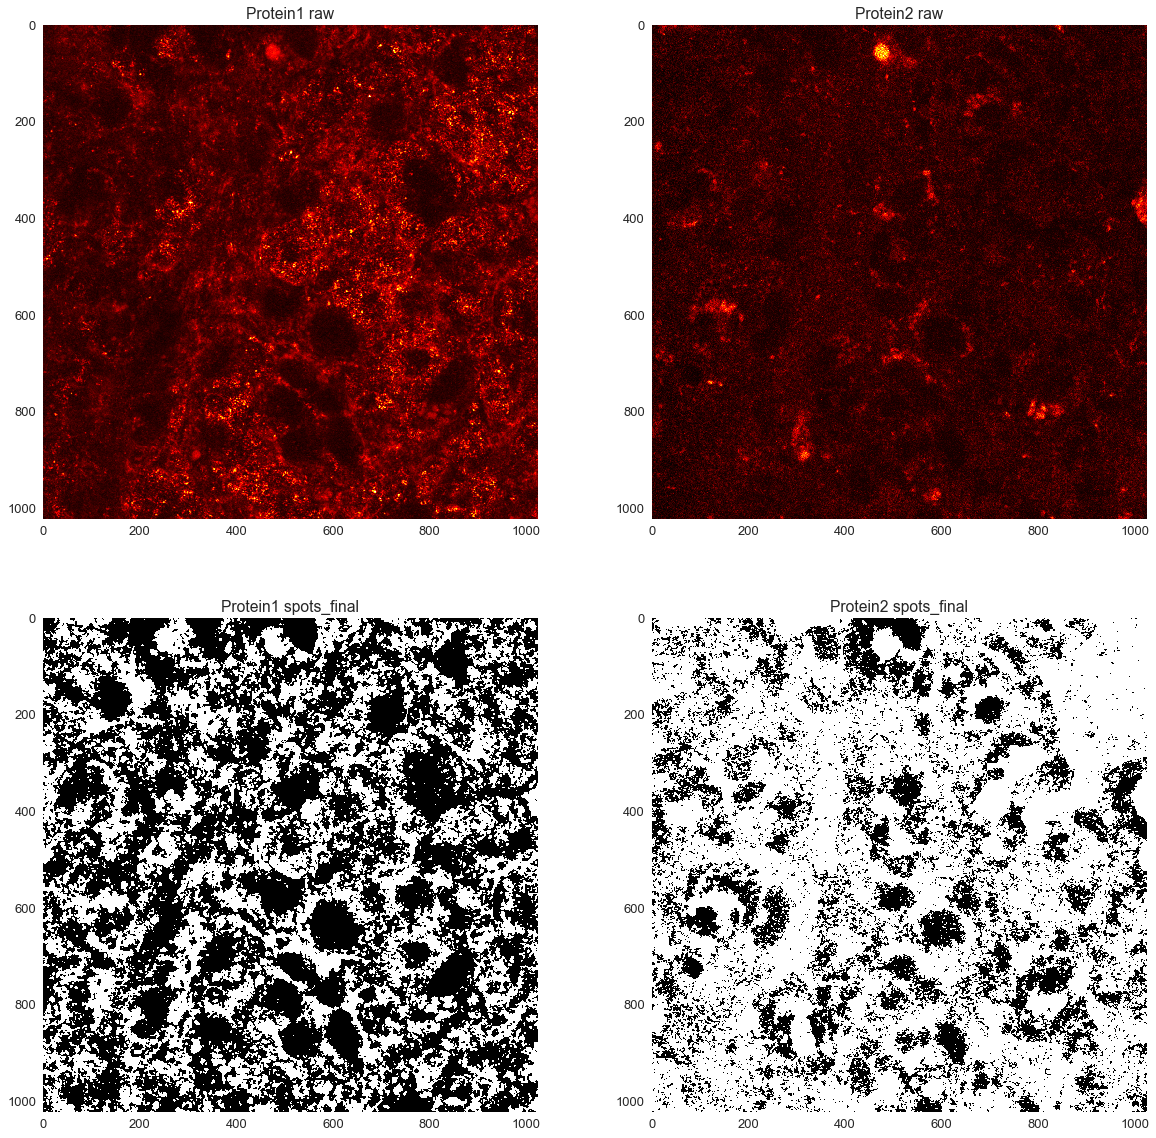

In [91]:
path=results['filename'][0]
print(path)
im = pims.open(path)
Protein1_image=im[Protein1_channel_no-1]
Protein2_image=im[Protein2_channel_no-1]

sigmagauss_Protein1=1 #Smoothing of Protein1 image
sigmagauss_Protein2=1 #Smoothing of Protein2 image

Protein1_smooth = ndi.filters.gaussian_filter(Protein1_image,sigmagauss_Protein1)
Protein2_smooth = ndi.filters.gaussian_filter(Protein2_image,sigmagauss_Protein2)

#adaptive thresholding - bg found by mean filter with SE
i_Protein1=151 #for SE of Protein1 image
i_Protein2=151 #for SE of Protein2 image

struct_Protein1 = (np.mgrid[:i_Protein1,:i_Protein1][0] - np.floor(i_Protein1/2))**2 + (np.mgrid[:i_Protein1,:i_Protein1][1] - np.floor(i_Protein1/2))**2 <= np.floor(i_Protein1/2)**2
struct_Protein2 = (np.mgrid[:i_Protein2,:i_Protein2][0] - np.floor(i_Protein2/2))**2 + (np.mgrid[:i_Protein2,:i_Protein2][1] - np.floor(i_Protein2/2))**2 <= np.floor(i_Protein2/2)**2
bg_Protein1 = rank.mean(Protein1_smooth, selem=struct_Protein1)
bg_Protein2 = rank.mean(Protein2_smooth, selem=struct_Protein2)
Protein1_spots = Protein1_smooth >= bg_Protein1
Protein2_spots = Protein2_smooth >= bg_Protein2

Protein1_spots_final=Protein1_spots
Protein2_spots_final=Protein2_spots

'''#improve with binary hole filling
Protein1_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(Protein1_spots))
Protein2_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(Protein2_spots))
#improve with binary closing
i2 = 3
struct2 = (np.mgrid[:i2,:i2][0] - np.floor(i2/2))**2 + (np.mgrid[:i2,:i2][1] - np.floor(i2/2))**2 <= np.floor(i2/2)**2
pad_size = i+2 #pad the spots image to avoid artifacts at the edges
padded_Protein1_spots = np.pad(Protein1_spots_holes_filled,pad_size,mode='reflect')
padded_Protein2_spots = np.pad(Protein2_spots_holes_filled,pad_size,mode='reflect')
Protein1_spots_final = ndi.binary_closing(np.logical_not(padded_Protein1_spots),structure=struct2)
Protein2_spots_final = ndi.binary_closing(np.logical_not(padded_Protein2_spots),structure=struct2)
#remove the padding from before
Protein1_spots_final = Protein1_spots_final[pad_size:-pad_size,pad_size:-pad_size]
Protein2_spots_final = Protein2_spots_final[pad_size:-pad_size,pad_size:-pad_size]'''
            
fig=plt.figure(figsize=(20,20))
fig.add_subplot(2,2,1)
plt.imshow(Protein1_image,interpolation='none',cmap='hot')
plt.title('Protein1 raw')
ax=plt.gca()
ax.grid(color='none')
fig.add_subplot(2,2,2)
plt.imshow(Protein2_image,interpolation='none',cmap='hot')
plt.title('Protein2 raw')
ax=plt.gca()
ax.grid(color='none')
fig.add_subplot(2,2,3)
plt.imshow(Protein1_spots_final,cmap='gray')
plt.title('Protein1 spots_final')
ax=plt.gca()
ax.grid(color='none')
fig.add_subplot(2,2,4)
plt.imshow(Protein2_spots_final,cmap='gray')
plt.title('Protein2 spots_final')
ax=plt.gca()
ax.grid(color='none')

In [6]:
results["filename"][76]

'/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180316_LTPStim_Cy3laserto20percent/35uMcyclo/20180316_12_LFS/20180316_12_LFS_Series2.tif'

#### After optimizing, run below to make segmentation masks for all images

In [92]:
print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    print('Calculating image no ' + str(i))
    path=results['filename'][i]
    im = pims.open(path)
    Protein1_image=im[Protein1_channel_no-1]
    Protein2_image=im[Protein2_channel_no-1]

    Protein1_smooth = ndi.filters.gaussian_filter(Protein1_image,sigmagauss_Protein1)
    Protein2_smooth = ndi.filters.gaussian_filter(Protein2_image,sigmagauss_Protein2)

    struct_Protein1 = (np.mgrid[:i_Protein1,:i_Protein1][0] - np.floor(i_Protein1/2))**2 + (np.mgrid[:i_Protein1,:i_Protein1][1] - np.floor(i_Protein1/2))**2 <= np.floor(i_Protein1/2)**2
    struct_Protein2 = (np.mgrid[:i_Protein2,:i_Protein2][0] - np.floor(i_Protein2/2))**2 + (np.mgrid[:i_Protein2,:i_Protein2][1] - np.floor(i_Protein2/2))**2 <= np.floor(i_Protein2/2)**2
    bg_Protein1 = rank.mean(Protein1_smooth, selem=struct_Protein1)
    bg_Protein2 = rank.mean(Protein2_smooth, selem=struct_Protein2)
    Protein1_spots = Protein1_smooth >= bg_Protein1
    Protein2_spots = Protein2_smooth >= bg_Protein2

    Protein1_spots_final=Protein1_spots
    Protein2_spots_final=Protein2_spots

    '''
    #improve with binary hole filling
    Protein1_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(Protein1_spots))
    Protein2_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(Protein2_spots))
    #improve with binary closing
    i2 = 3
    struct2 = (np.mgrid[:i2,:i2][0] - np.floor(i2/2))**2 + (np.mgrid[:i2,:i2][1] - np.floor(i2/2))**2 <= np.floor(i2/2)**2
    pad_size = i+2 #pad the spots image to avoid artifacts at the edges
    padded_Protein1_spots = np.pad(Protein1_spots_holes_filled,pad_size,mode='reflect')
    padded_Protein2_spots = np.pad(Protein2_spots_holes_filled,pad_size,mode='reflect')
    Protein1_spots_final = ndi.binary_closing(np.logical_not(padded_Protein1_spots),structure=struct2)
    Protein2_spots_final = ndi.binary_closing(np.logical_not(padded_Protein2_spots),structure=struct2)
    #remove the padding from before
    Protein1_spots_final = Protein1_spots_final[pad_size:-pad_size,pad_size:-pad_size]
    Protein2_spots_final = Protein2_spots_final[pad_size:-pad_size,pad_size:-pad_size]'''

    results["Protein1 colour - spots mask"].append(Protein1_spots_final)
    results["Protein2 colour - spots mask"].append(Protein2_spots_final)

Total number of images: 72
Calculating image no 0
Calculating image no 1


/Users/taldankovich/anaconda/lib/python3.6/site-packages/tifffile/tifffile.py:2784: UserWarning: invalid page offset (2117224)
  warnings.warn("invalid page offset (%i)" % offset)


Calculating image no 2
Calculating image no 3
Calculating image no 4
Calculating image no 5
Calculating image no 6
Calculating image no 7
Calculating image no 8
Calculating image no 9
Calculating image no 10
Calculating image no 11
Calculating image no 12
Calculating image no 13
Calculating image no 14
Calculating image no 15
Calculating image no 16
Calculating image no 17
Calculating image no 18
Calculating image no 19
Calculating image no 20
Calculating image no 21
Calculating image no 22
Calculating image no 23
Calculating image no 24
Calculating image no 25
Calculating image no 26
Calculating image no 27
Calculating image no 28
Calculating image no 29
Calculating image no 30
Calculating image no 31
Calculating image no 32
Calculating image no 33
Calculating image no 34
Calculating image no 35
Calculating image no 36
Calculating image no 37
Calculating image no 38
Calculating image no 39
Calculating image no 40
Calculating image no 41
Calculating image no 42
Calculating image no 43


#### Verify the segmentation (look at a random subset of raw images and their masks)

/Users/taldankovich/anaconda/lib/python3.6/site-packages/tifffile/tifffile.py:2784: UserWarning: invalid page offset (2117224)
  warnings.warn("invalid page offset (%i)" % offset)


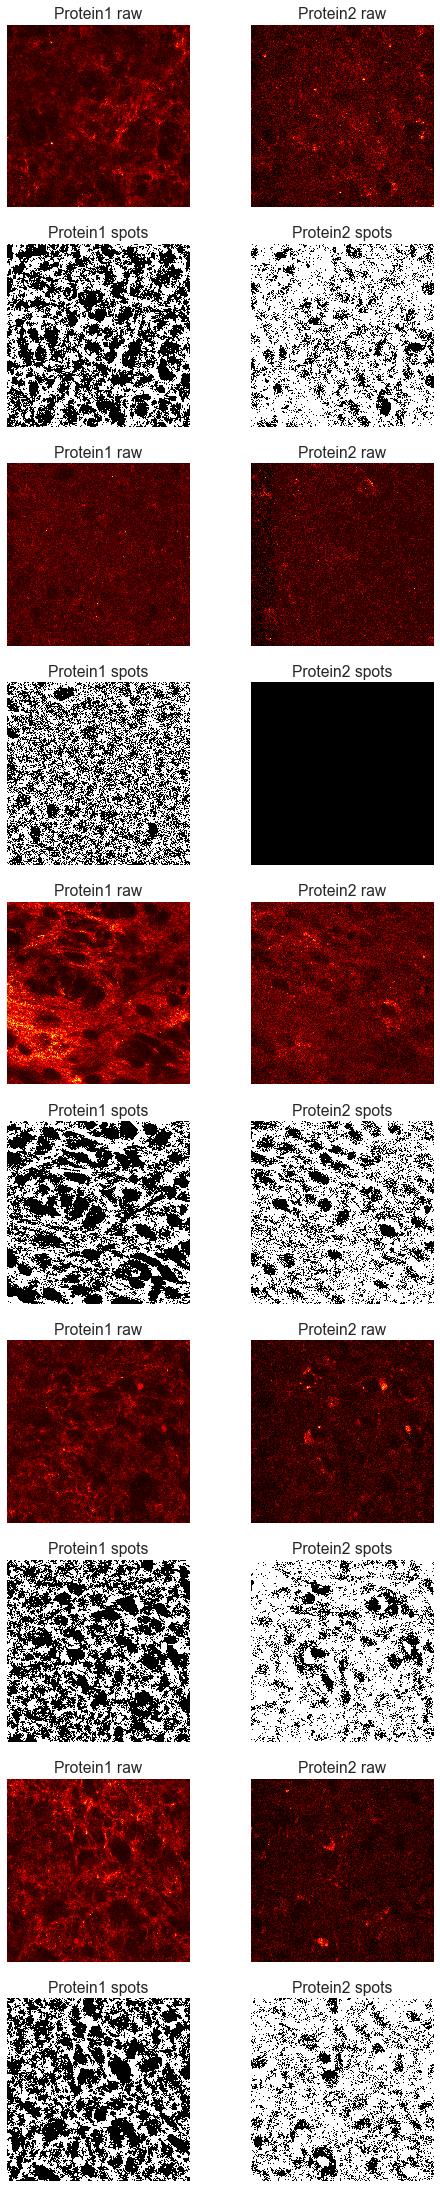

In [93]:
fig=plt.figure(figsize=(8,80))
figno=1
for im in range(0,5):
    randindex=np.random.randint(1,len(results["filename"]))
    path=results["filename"][randindex]
    image = pims.open(path)
    Protein1_image=image[Protein1_channel_no-1]
    Protein2_image=image[Protein2_channel_no-1]
    Protein1_spots=results["Protein1 colour - spots mask"][randindex]
    Protein2_spots=results["Protein2 colour - spots mask"][randindex]
    
    fig.add_subplot(20,2,figno)
    plt.imshow(Protein1_image,interpolation='none',cmap='hot')
    plt.title('Protein1 raw')
    plt.ylabel(path)
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(20,2,figno+1)
    plt.imshow(Protein2_image,interpolation='none',cmap='hot')
    plt.title('Protein2 raw')
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(20,2,figno+2)
    plt.imshow(Protein1_spots,interpolation='none',cmap='gray')
    plt.title('Protein1 spots')
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(20,2,figno+3)
    plt.imshow(Protein2_spots,interpolation='none',cmap='gray')
    plt.title('Protein2 spots')

    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    figno=figno+4

### Batch analyse images, after creating the segmentation masks

In [94]:
print('Total number of images: ' + str(len(results['filename'])))
for i in range(0,len(results["filename"])):    
    print('Calculating image no ' + str(i))
    path=results['filename'][i]
    im = pims.open(path)
    Protein1_image=im[Protein1_channel_no-1]
    Protein2_image=im[Protein2_channel_no-1]
    #read spots masks
    Protein1_spots=results["Protein1 colour - spots mask"][i]
    Protein2_spots=results["Protein2 colour - spots mask"][i]
    #label the spots
    spots_Protein1_labels,_ = ndi.label(Protein1_spots)
    spots_Protein2_labels,_ = ndi.label(Protein2_spots)
    #calcuProtein2 results
    Protein1_spots_intensities=np.zeros((len(np.unique(spots_Protein1_labels)),1))
    Protein1_spots_areas=np.zeros((len(np.unique(spots_Protein1_labels)),1))
    Protein1_spots_intensities_maskedbyProtein2=np.zeros((len(np.unique(spots_Protein2_labels)),1))
    Protein2_spots_intensities=np.zeros((len(np.unique(spots_Protein2_labels)),1))
    Protein2_spots_areas=np.zeros((len(np.unique(spots_Protein2_labels)),1))
    spots_Protein2_minus_Protein1_int=np.zeros((len(np.unique(spots_Protein1_labels)),1))

    for spotno in np.unique(spots_Protein1_labels)[1:]:
        Protein1_spots_mask = spots_Protein1_labels==spotno
        Protein1_spots_intensities[(spotno)]=np.mean(Protein1_image[Protein1_spots_mask])
        Protein1_spots_areas[spotno]=np.sum(Protein1_spots_mask)
        
        #calculation for Protein2 minus Protein1, based on Protein1 spots only
        a=Protein2_image[Protein1_spots_mask]
        b=Protein1_image[Protein1_spots_mask]
        spots_Protein2_minus_Protein1_int[spotno]=np.mean(np.divide([a-b],[a+b]))
        
    for spotnol in np.unique(spots_Protein2_labels)[1:]:
        Protein2_spots_mask= spots_Protein2_labels==spotnol
        Protein2_spots_intensities[spotnol]=np.mean(Protein2_image[Protein2_spots_mask])
        Protein2_spots_areas[spotnol]=np.sum(Protein2_spots_mask)
        Protein1_spots_intensities_maskedbyProtein2=np.mean(Protein1_image[Protein2_spots_mask])
        Protein1_spots_intensities_notProtein2=np.mean(Protein1_image[np.invert(Protein2_spots_mask)])

    #the following results are calculated on the raw data

    #results based on spot segmentation    
    results["Protein1 colour - Mean intensity of spots"].append(np.mean(Protein1_spots_intensities))
    results["Protein2 colour - Mean intensity of spots"].append(np.mean(Protein2_spots_intensities))
    results["Protein1 colour - Total no. of spots in FOV"].append(len(Protein1_spots_intensities))
    results["Protein2 colour - Total no. of spots in FOV"].append(len(Protein2_spots_intensities))
    results["Protein1 colour - Mean spot area [nm]"].append(np.mean(Protein1_spots_areas))
    results["Protein2 colour - Mean spot area [nm]"].append(np.mean(Protein2_spots_areas))
    results["Protein1 colour - Mean intensity, masked by Protein2 spots"].append(np.mean(Protein1_spots_intensities_maskedbyProtein2))
    results["Protein1 colour - Mean intensity, outside of Protein2 spots"].append(np.mean(Protein1_spots_intensities_notProtein2))

    #global results
    results["Protein1 colour - Raw mean intensity"].append(np.mean(Protein1_image))
    results["Protein2 colour - Raw mean intensity"].append(np.mean(Protein2_image))
    results["Mean correlation coefficient Protein1/Protein2"].append(corr2(Protein1_image,Protein2_image))
    results["Mean colour bias of a pixel (Protein1=-1<x<1=Protein2)"].append(np.mean(spots_Protein2_minus_Protein1_int))

Total number of images: 72
Calculating image no 0


/Users/taldankovich/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in true_divide


Calculating image no 1


/Users/taldankovich/anaconda/lib/python3.6/site-packages/tifffile/tifffile.py:2784: UserWarning: invalid page offset (2117224)
  warnings.warn("invalid page offset (%i)" % offset)


Calculating image no 2
Calculating image no 3
Calculating image no 4
Calculating image no 5
Calculating image no 6
Calculating image no 7
Calculating image no 8
Calculating image no 9
Calculating image no 10
Calculating image no 11
Calculating image no 12
Calculating image no 13
Calculating image no 14
Calculating image no 15
Calculating image no 16
Calculating image no 17
Calculating image no 18
Calculating image no 19
Calculating image no 20
Calculating image no 21
Calculating image no 22
Calculating image no 23
Calculating image no 24
Calculating image no 25
Calculating image no 26
Calculating image no 27
Calculating image no 28
Calculating image no 29
Calculating image no 30
Calculating image no 31
Calculating image no 32
Calculating image no 33
Calculating image no 34
Calculating image no 35
Calculating image no 36
Calculating image no 37
Calculating image no 38
Calculating image no 39
Calculating image no 40
Calculating image no 41
Calculating image no 42
Calculating image no 43


### Make a clean figure of an experimental condition, with merged image and scalebar

In [ ]:
experimental_condition_to_displax='LFS' #'1 day' or '1 day + bic'

medfiltarray=[3,3] #play with med filter size

fig=plt.figure(figsize=(10,250))
no_of_ims_in_condition = sum( x == experimental_condition_to_display for x in results["exp condition"] )
print(no_of_ims_in_condition)
counter=1

for i in range(0,len(results["filename"])): 
    if (results["exp condition"][i]==experimental_condition_to_display and counter<15):
        path=results['filename'][i]
        im = pims.open(path)
        Protein1_image=im[Protein1_channel_no-1]
        Protein2_image=im[Protein2_channel_no-1]
       
        #some basic preprocessing: smoothing (noise reduction) with med filter, and contrast adjustment
        Protein1_smoothed=ndi.filters.median_filter(Protein1_image,medfiltarray)
        v_min1, v_max1 = np.percentile(Protein1_smoothed, (0.2, 99.8))
        Protein1_smoothed_adjusted=exposure.rescale_intensity(Protein1_smoothed, in_range=(v_min1, v_max1))
        Protein2_smoothed=ndi.filters.median_filter(Protein2_image,medfiltarray)
        v_min2, v_max2 = np.percentile(Protein2_smoothed, (0.2, 99.8))
        Protein2_smoothed_adjusted=exposure.rescale_intensity(Protein2_smoothed, in_range=(v_min2, v_max2))

        #make Protein1 image red and Protein2 image green
        greencmap = clr.LinearSegmentedColormap.from_list('customred', ['#000000','#06C420'], N=256)
        redcmap=clr.LinearSegmentedColormap.from_list('customred', ['#000000','#FD0120'], N=256)

        normProtein1 = Protein1_smoothed_adjusted.astype(np.float32) # convert to float
        normProtein1 -= normProtein1.min() # ensure the minimal value is 0.0
        normProtein1 /= normProtein1.max() # maximum value in image is now 1.0
        normProtein2 = Protein2_smoothed_adjusted.astype(np.float32) # convert to float
        normProtein2 -= normProtein2.min() # ensure the minimal value is 0.0
        normProtein2 /= normProtein2.max() # maximum value in image is now 1.0

        Protein2_ingreen=greencmap(normProtein2)
        Protein1_inred=redcmap(normProtein1)

        #make composite with a scalebar
        comp=Image.blend(toimage(Protein1_inred),toimage(Protein2_ingreen),0.5)
        micronsperpixel=0.0962
        scalebar = ScaleBar(dx=micronsperpixel,units='um',color='white',length_fraction=0.16,box_color='none') # 1 pixel = 0.2 meter

        fig.add_subplot(no_of_ims_in_condition,3,counter)
        plt.imshow(Protein1_inred,interpolation='none')
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.gca().set_aspect('equal')
        plt.gca().grid(color='none')

        fig.add_subplot(no_of_ims_in_condition,3,(counter+1))
        plt.imshow(Protein2_ingreen,interpolation='none')
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.gca().set_aspect('equal')
        plt.gca().grid(color='none')

        fig.add_subplot(no_of_ims_in_condition,3,(counter+2))
        plt.imshow(comp)
        plt.gca().add_artist(scalebar)
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.gca().set_aspect('equal')
        plt.gca().grid(color='none')

        counter=counter+3

plt.subplots_adjust(wspace=0, hspace=0)

## Plots

In [95]:
df=pd.DataFrame(results)

In [96]:
df["Drug"] = "None"

In [98]:
#df[df[Slice_id]]
df.loc[df['Slice_id'].str.contains('DMSO'), 'Drug'] = 'DMSO'
df.loc[df['Slice_id'].str.contains('NoDrug'), 'Drug'] = 'No Drugs'
df.loc[df['Slice_id'].str.contains('GM6001'), 'Drug'] = 'GM6001'


In [99]:
df.head()

,Mean colour bias of a pixel (Protein1=-1<x<1=Protein2),Mean correlation coefficient Protein1/Protein2,Protein1 colour - Mean intensity of spots,"Protein1 colour - Mean intensity, masked by Protein2 spots","Protein1 colour - Mean intensity, outside of Protein2 spots",Protein1 colour - Mean spot area [nm],Protein1 colour - Raw mean intensity,Protein1 colour - Total no. of spots in FOV,Protein1 colour - spots mask,Protein2 colour - Mean intensity of spots,Protein2 colour - Mean spot area [nm],Protein2 colour - Raw mean intensity,Protein2 colour - Total no. of spots in FOV,Protein2 colour - spots mask,Slice_id,exp condition,filename,Drug
0,inf,0.036589,42.168606,22.00,34.473331,153.212924,34.473319,2832,"[[False, False, False, False, False, False, Fa...",11.314500,298.269841,10.648815,2583,"[[False, False, False, False, False, False, Fa...",0411and0412_LTPStim_Cy3laserto25percent/DMSO/2...,LFS,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/O...,DMSO
1,7.082166,0.091677,26.561847,18.00,23.320179,152.129042,23.320174,3154,"[[True, True, True, True, True, True, True, Tr...",9.449580,4424.512931,8.125261,232,"[[True, True, True, True, True, True, True, Tr...",0411and0412_LTPStim_Cy3laserto25percent/DMSO/2...,LFS,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/O...,DMSO
2,9.102812,0.050745,19.545413,14.60,17.855121,193.916288,17.855105,2640,"[[True, True, True, True, True, True, True, Tr...",8.945767,33665.709677,7.983458,31,"[[True, True, True, True, True, True, True, Tr...",0411and0412_LTPStim_Cy3laserto25percent/DMSO/2...,LFS,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/O...,DMSO
3,6.578597,0.121678,28.563519,22.75,24.625082,169.622491,24.625074,2890,"[[False, False, False, False, False, False, Fa...",9.726059,1579.979133,8.587055,623,"[[True, True, True, True, True, True, True, Tr...",0411and0412_LTPStim_Cy3laserto25percent/DMSO/2...,LFS,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/O...,DMSO
4,6.508648,0.200845,28.819265,16.00,25.135462,172.796269,25.135453,2680,"[[True, True, True, True, True, True, True, Tr...",10.127055,1242.496749,8.988940,769,"[[True, True, True, True, True, True, True, Tr...",0411and0412_LTPStim_Cy3laserto25percent/DMSO/2...,LFS,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/O...,DMSO


### Write to pickle

In [100]:
output = os.path.abspath(os.path.join(expdir, 'results.csv'))

df.to_csv(output)

### Read previously stored pickle file

In [ ]:
print(output)

In [54]:



output = os.path.abspath(os.path.join(expdir, 'results.csv'))
print(output)

df=pd.DataFrame.from_csv(output)

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20180305_LTPStim_BetweenFrames_notdoneimaging/results.csv


### Bar plots of all of the data, no statistics

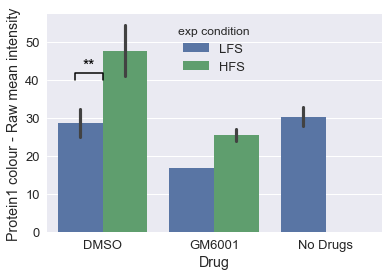

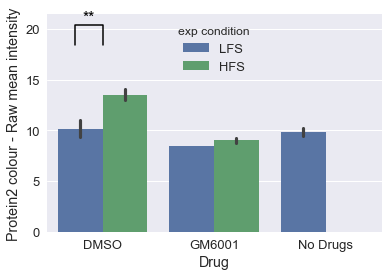

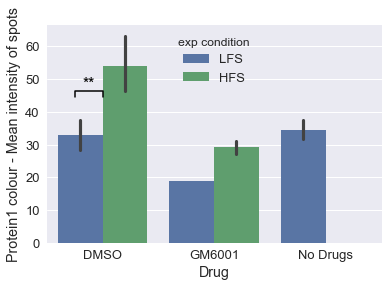

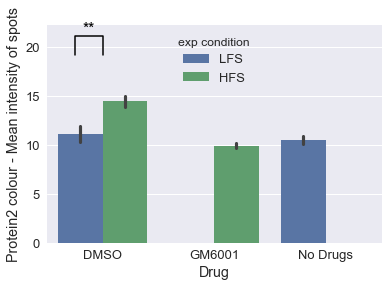

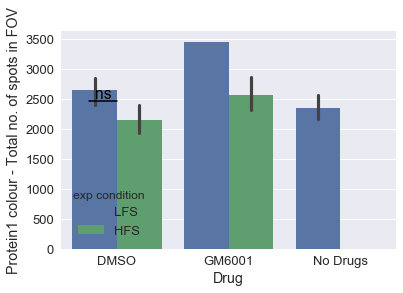

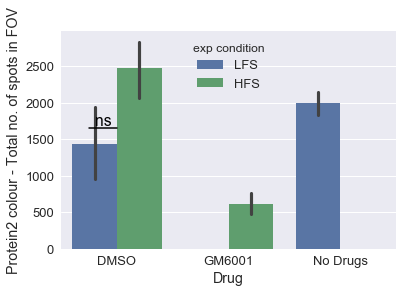

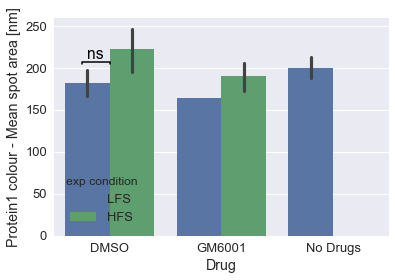

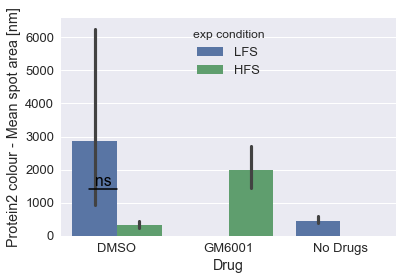

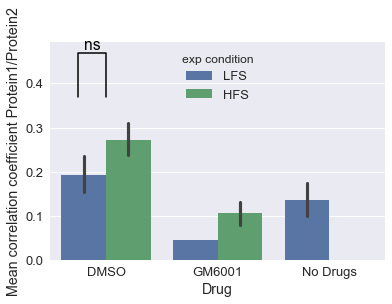

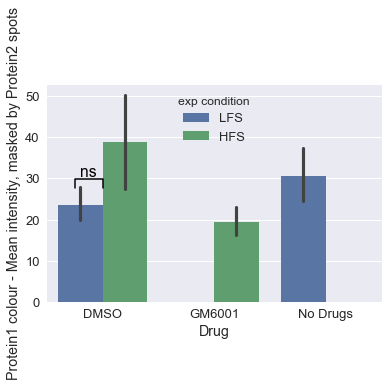

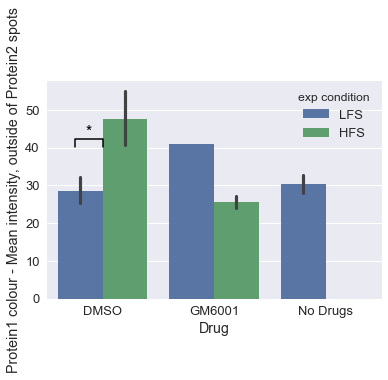

In [101]:
sns.set(font_scale=1.3)


fig1=plt.figure()
d=sns.barplot(y ="Protein1 colour - Raw mean intensity", x="Drug",hue="exp condition",data=df)#ci='sd',
#order=["HFS","LFS","Untreated"]) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein1 colour - Raw mean intensity", x="Drug",hue="exp condition",data=df,color='black')
#d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Raw mean intensity']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Raw mean intensity']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = -0.25, 0   # columns 'HFS' and 'LFS'
y, h, col = df['Protein1 colour - Raw mean intensity'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig1.savefig(output+'_'+'plot1.png',bbox_inches='tight')

fig2=plt.figure()
d=sns.barplot(y ='Protein2 colour - Raw mean intensity', x="Drug",hue="exp condition",data=df) #ci='sd',
                 #order=["HFS","LFS","Untreated"]) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein2 colour - Raw mean intensity", x="Drug",hue="exp condition",data=df,color='black')
#d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Raw mean intensity']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Raw mean intensity']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = -0.25, 0  # columns 'HFS' and 'LFS'
y, h, col = df['Protein2 colour - Raw mean intensity'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig2.savefig(output+'_'+'plot2.png',bbox_inches='tight')

fig3=plt.figure()
d=sns.barplot(y ='Protein1 colour - Mean intensity of spots', x="Drug",hue="exp condition",data=df) #ci='sd',
                 #order=["HFS","LFS","Untreated"]) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein1 colour - Mean intensity of spots", x="Drug",hue="exp condition",data=df,color='black')
#d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean intensity of spots']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean intensity of spots']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = -0.25, 0   # columns 'HFS' and 'LFS'
y, h, col = df['Protein1 colour - Mean intensity of spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig3.savefig(output+'_'+'plot3.png',bbox_inches='tight')

fig4=plt.figure()
d=sns.barplot(y ='Protein2 colour - Mean intensity of spots', x="Drug",hue="exp condition",data=df) #ci='sd',
                 #order=["HFS","LFS","Untreated"]) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein2 colour - Mean intensity of spots", x="Drug",hue="exp condition",data=df,color='black')
#d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Mean intensity of spots']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Mean intensity of spots']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = -0.25, 0   # columns 'HFS' and 'LFS'
y, h, col = df['Protein2 colour - Mean intensity of spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig4.savefig(output+'_'+'plot4.png',bbox_inches='tight')

fig5=plt.figure()
d=sns.barplot(y ='Protein1 colour - Total no. of spots in FOV', x="Drug",hue="exp condition",data=df) #ci='sd',
                 #order=["HFS","LFS","Untreated"]) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein1 colour - Total no. of spots in FOV", x="Drug",hue="exp condition",data=df,color='black')
#d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Total no. of spots in FOV']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Total no. of spots in FOV']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = -0.25, 0   # columns 'HFS' and 'LFS'
y, h, col = df['Protein1 colour - Total no. of spots in FOV'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig5.savefig(output+'_'+'plot5.png',bbox_inches='tight')

fig6=plt.figure()
d=sns.barplot(y ='Protein2 colour - Total no. of spots in FOV', x="Drug",hue="exp condition",data=df) #ci='sd',
                 #order=["HFS","LFS","Untreated"]) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein2 colour - Total no. of spots in FOV", x="Drug",hue="exp condition",data=df,color='black')
#d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Total no. of spots in FOV']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Total no. of spots in FOV']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = -0.25, 0  # columns 'HFS' and 'LFS'
y, h, col = df['Protein2 colour - Total no. of spots in FOV'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig6.savefig(output+'_'+'plot6.png',bbox_inches='tight')

fig7=plt.figure()
d=sns.barplot(y ='Protein1 colour - Mean spot area [nm]', x="Drug",hue="exp condition",data=df) #ci='sd',
                 #order=["HFS","LFS","Untreated"]) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein1 colour - Mean spot area [nm]", x="Drug",hue="exp condition",data=df,color='black')
#d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean spot area [nm]']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean spot area [nm]']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = -0.25, 0   # columns 'HFS' and 'LFS'
y, h, col = df['Protein1 colour - Mean spot area [nm]'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig7.savefig(output+'_'+'plot7.png',bbox_inches='tight')

fig8=plt.figure()
d=sns.barplot(y ='Protein2 colour - Mean spot area [nm]', x="Drug",hue="exp condition",data=df) #ci='sd',
                 #order=["HFS","LFS","Untreated"]) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein2 colour - Mean spot area [nm]", x="Drug",hue="exp condition",data=df,color='black')
#d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Mean spot area [nm]']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Mean spot area [nm]']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = -0.25, 0   # columns 'HFS' and 'LFS'
y, h, col = df['Protein2 colour - Mean spot area [nm]'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig8.savefig(output+'_'+'plot8.png',bbox_inches='tight')

fig9=plt.figure()
d=sns.barplot(y ='Mean correlation coefficient Protein1/Protein2', x="Drug",hue="exp condition",data=df) #ci='sd',
                 #order=["HFS","LFS","Untreated"]) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Mean correlation coefficient Protein1/Protein2", x="Drug",hue="exp condition",data=df,color='black')
#d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Mean correlation coefficient Protein1/Protein2']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Mean correlation coefficient Protein1/Protein2']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = -0.25, 0   # columns 'HFS' and 'LFS'
y, h, col = df['Mean correlation coefficient Protein1/Protein2'].mean() + 0.2, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig9.savefig(output+'_'+'plot9.png',bbox_inches='tight')

fig10=plt.figure()
d=sns.barplot(y ='Protein1 colour - Mean intensity, masked by Protein2 spots', x="Drug",hue="exp condition",data=df) #ci='sd',
                 #order=["HFS","LFS","Untreated"]) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein1 colour - Mean intensity, masked by Protein2 spots", x="Drug",hue="exp condition",data=df,color='black')
#d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean intensity, masked by Protein2 spots']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean intensity, masked by Protein2 spots']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = -0.25, 0   # columns 'HFS' and 'LFS'
y, h, col = df['Protein1 colour - Mean intensity, masked by Protein2 spots'].mean() + 0.2, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig10.savefig(output+'_'+'plot10.png',bbox_inches='tight')

fig11=plt.figure()
d=sns.barplot(y ='Protein1 colour - Mean intensity, outside of Protein2 spots', x="Drug",hue="exp condition",data=df) #ci='sd',
                 #order=["HFS","LFS","Untreated"]) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein1 colour - Mean intensity, outside of Protein2 spots", x="Drug",hue="exp condition",data=df,color='black')
#d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean intensity, outside of Protein2 spots']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean intensity, outside of Protein2 spots']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = -0.25, 0   # columns 'HFS' and 'LFS'
y, h, col = df['Protein1 colour - Mean intensity, outside of Protein2 spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig11.savefig(output+'_'+'plot11.png',bbox_inches='tight')






In [ ]:
sns.set(font_scale=1.3)


fig1=plt.figure()
d=sns.barplot(y ="Protein1 colour - Raw mean intensity", x="Drug",hue="exp condition",data=df,#ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein1 colour - Raw mean intensity", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Raw mean intensity']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Raw mean intensity']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein1 colour - Raw mean intensity'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig1.savefig(output+'_'+'plot1.png',bbox_inches='tight')

fig2=plt.figure()
d=sns.barplot(y ='Protein2 colour - Raw mean intensity', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein2 colour - Raw mean intensity", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Raw mean intensity']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Raw mean intensity']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein2 colour - Raw mean intensity'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig2.savefig(output+'_'+'plot2.png',bbox_inches='tight')

fig3=plt.figure()
d=sns.barplot(y ='Protein1 colour - Mean intensity of spots', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein1 colour - Mean intensity of spots", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean intensity of spots']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean intensity of spots']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein1 colour - Mean intensity of spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig3.savefig(output+'_'+'plot3.png',bbox_inches='tight')

fig4=plt.figure()
d=sns.barplot(y ='Protein2 colour - Mean intensity of spots', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein2 colour - Mean intensity of spots", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Mean intensity of spots']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Mean intensity of spots']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein2 colour - Mean intensity of spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig4.savefig(output+'_'+'plot4.png',bbox_inches='tight')

fig5=plt.figure()
d=sns.barplot(y ='Protein1 colour - Total no. of spots in FOV', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein1 colour - Total no. of spots in FOV", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Total no. of spots in FOV']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Total no. of spots in FOV']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein1 colour - Total no. of spots in FOV'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig5.savefig(output+'_'+'plot5.png',bbox_inches='tight')

fig6=plt.figure()
d=sns.barplot(y ='Protein2 colour - Total no. of spots in FOV', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein2 colour - Total no. of spots in FOV", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Total no. of spots in FOV']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Total no. of spots in FOV']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein2 colour - Total no. of spots in FOV'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig6.savefig(output+'_'+'plot6.png',bbox_inches='tight')

fig7=plt.figure()
d=sns.barplot(y ='Protein1 colour - Mean spot area [nm]', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein1 colour - Mean spot area [nm]", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean spot area [nm]']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean spot area [nm]']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein1 colour - Mean spot area [nm]'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig7.savefig(output+'_'+'plot7.png',bbox_inches='tight')

fig8=plt.figure()
d=sns.barplot(y ='Protein2 colour - Mean spot area [nm]', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein2 colour - Mean spot area [nm]", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Mean spot area [nm]']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Mean spot area [nm]']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein2 colour - Mean spot area [nm]'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig8.savefig(output+'_'+'plot8.png',bbox_inches='tight')

fig9=plt.figure()
d=sns.barplot(y ='Mean correlation coefficient Protein1/Protein2', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Mean correlation coefficient Protein1/Protein2", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Mean correlation coefficient Protein1/Protein2']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Mean correlation coefficient Protein1/Protein2']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Mean correlation coefficient Protein1/Protein2'].mean() + 0.2, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig9.savefig(output+'_'+'plot9.png',bbox_inches='tight')

fig10=plt.figure()
d=sns.barplot(y ='Protein1 colour - Mean intensity, masked by Protein2 spots', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein1 colour - Mean intensity, masked by Protein2 spots", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean intensity, masked by Protein2 spots']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean intensity, masked by Protein2 spots']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein1 colour - Mean intensity, masked by Protein2 spots'].mean() + 0.2, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig10.savefig(output+'_'+'plot10.png',bbox_inches='tight')

fig11=plt.figure()
d=sns.barplot(y ='Protein1 colour - Mean intensity, outside of Protein2 spots', x="Drug",hue="exp condition",data=df, #ci='sd',
                 ) #order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Protein1 colour - Mean intensity, outside of Protein2 spots", x="Drug",hue="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["HFS","LFS","Untreated"],rotation=90) #d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
Protein1_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean intensity, outside of Protein2 spots']
Protein1_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean intensity, outside of Protein2 spots']
[stat,pval]=stats.ttest_ind(Protein1_LFS, Protein1_HFS)
#print(pval)
x1, x2 = 0, 1   # columns 'HFS' and 'LFS'
y, h, col = df['Protein1 colour - Mean intensity, outside of Protein2 spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()
fig11.savefig(output+'_'+'plot11.png',bbox_inches='tight')







In [ ]:
#statistics with scipy, plots with seaborn
sns.set(font_scale=1.2)

#raw mean intensity Protein1
Protein1rawint_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Raw mean intensity']
Protein1rawint_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Raw mean intensity']
[stat,pval]=stats.ttest_ind(Protein1rawint_LFS, Protein1rawint_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein1 colour - Raw mean intensity', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein1 colour - Raw mean intensity'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#raw mean intensity Protein2
Protein2rawint_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Raw mean intensity']
Protein2rawint_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Raw mean intensity']
[stat,pval]=stats.ttest_ind(Protein2rawint_LFS, Protein2rawint_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein2 colour - Raw mean intensity', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein2 colour - Raw mean intensity'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#raw mean intensity Protein1 spots
Protein1spotint_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean intensity of spots']
Protein1spotint_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean intensity of spots']
[stat,pval]=stats.ttest_ind(Protein1spotint_LFS, Protein1spotint_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein1 colour - Mean intensity of spots', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein1 colour - Mean intensity of spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#raw mean intensity Protein2 spots
Protein2spotint_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Mean intensity of spots']
Protein2spotint_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Mean intensity of spots']
[stat,pval]=stats.ttest_ind(Protein2spotint_LFS, Protein2spotint_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein2 colour - Mean intensity of spots', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein2 colour - Mean intensity of spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#NO of Protein1 spots in FOV
Protein1spotno_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Total no. of spots in FOV']
Protein1spotno_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Total no. of spots in FOV']
[stat,pval]=stats.ttest_ind(Protein1spotno_LFS, Protein1spotno_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein1 colour - Total no. of spots in FOV', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein1 colour - Total no. of spots in FOV'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#NO of Protein2 spots in FOV
Protein2spotno_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Total no. of spots in FOV']
Protein2spotno_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Total no. of spots in FOV']
[stat,pval]=stats.ttest_ind(Protein2spotno_LFS, Protein2spotno_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein2 colour - Total no. of spots in FOV', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein2 colour - Total no. of spots in FOV'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#Spot Area of Protein1 
Protein1spotarea_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean spot area [nm]']
Protein1spotarea_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean spot area [nm]']
[stat,pval]=stats.ttest_ind(Protein1spotarea_LFS, Protein1spotarea_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein1 colour - Mean spot area [nm]', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein1 colour - Mean spot area [nm]'].mean() + 200, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#Protein2 spot area
Protein2spotarea_LFS = df[df['exp condition'] == 'LFS']['Protein2 colour - Mean spot area [nm]']
Protein2spotarea_HFS = df[df['exp condition'] == 'HFS']['Protein2 colour - Mean spot area [nm]']
[stat,pval]=stats.ttest_ind(Protein2spotarea_LFS, Protein2spotarea_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein2 colour - Mean spot area [nm]', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein2 colour - Mean spot area [nm]'].mean() + 200, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#Corrcoeff Protein1 Protein2
Corrcoeff_LFS = df[df['exp condition'] == 'LFS']['Mean correlation coefficient Protein1/Protein2']
Corrcoeff_HFS = df[df['exp condition'] == 'HFS']['Mean correlation coefficient Protein1/Protein2']
[stat,pval]=stats.ttest_ind(Corrcoeff_LFS, Corrcoeff_HFS)
print(pval)
sns.factorplot(kind='bar', y='Mean correlation coefficient Protein1/Protein2', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Mean correlation coefficient Protein1/Protein2'].mean()+0.2 , 0.2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#Protein1 intensity, masked by Protein2
Protein1synapsesint_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean intensity, masked by Protein2 spots']
Protein1synapsesint_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean intensity, masked by Protein2 spots']
[stat,pval]=stats.ttest_ind(Protein1synapsesint_LFS, Protein1synapsesint_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein1 colour - Mean intensity, masked by Protein2 spots', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein1 colour - Mean intensity, masked by Protein2 spots'].mean() + 12, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#Protein1 intensity, not masked by Protein2
Protein1notsynapsesint_LFS = df[df['exp condition'] == 'LFS']['Protein1 colour - Mean intensity, outside of Protein2 spots']
Protein1notsynapsesint_HFS = df[df['exp condition'] == 'HFS']['Protein1 colour - Mean intensity, outside of Protein2 spots']
[stat,pval]=stats.ttest_ind(Protein1notsynapsesint_LFS, Protein1notsynapsesint_HFS)
print(pval)
sns.factorplot(kind='bar', y='Protein1 colour - Mean intensity, outside of Protein2 spots', x ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'LFS' and 'HFS'
y, h, col = df['Protein1 colour - Mean intensity, outside of Protein2 spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()


In [ ]:
sns.set(font_scale=1.5)

fig12=plt.figure(figsize=(10,10))
d=sns.boxplot(y ='Protein1 colour - Raw mean intensity', x='Slice_id',data=df,hue='exp condition')
d.set_xticklabels('')
plt.show()
fig12.savefig(output+'_'+'plot_individual_slices.png',bbox_inches='tight')



In [102]:
df.Drug


0         DMSO
1         DMSO
2         DMSO
3         DMSO
4         DMSO
5         DMSO
6         DMSO
7         DMSO
8         DMSO
9         DMSO
10        DMSO
11        DMSO
12        DMSO
13        DMSO
14        DMSO
15        DMSO
16        DMSO
17        DMSO
18        DMSO
19        DMSO
20        DMSO
21        DMSO
22        DMSO
23        DMSO
24        DMSO
25        DMSO
26        DMSO
27        DMSO
28        DMSO
29        DMSO
        ...   
42      GM6001
43      GM6001
44      GM6001
45      GM6001
46      GM6001
47      GM6001
48    No Drugs
49    No Drugs
50    No Drugs
51    No Drugs
52    No Drugs
53    No Drugs
54    No Drugs
55    No Drugs
56    No Drugs
57    No Drugs
58    No Drugs
59    No Drugs
60    No Drugs
61    No Drugs
62    No Drugs
63    No Drugs
64    No Drugs
65    No Drugs
66    No Drugs
67    No Drugs
68    No Drugs
69    No Drugs
70    No Drugs
71    No Drugs
Name: Drug, dtype: object

## Calculate enrichment value (of HFS over LFS)

In [ ]:
# make new dataframe for collecting results from all exps
HFSoverLFS_many_exps = {"Exp Date":[],
                        "Treatment":[],
                        "Ratio HFS/LFS Protein 1":[],
                       "Ratio HFS/LFS Protein 2":[]}
Experiments_summary_of_HFS_LFS_comp=pd.DataFrame(HFSoverLFS_many_exps)

In [103]:
Experiments_summary_of_HFS_LFS_comp=pd.DataFrame.from_csv('/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/LTPanalysis/Experiments_summary_of_HFS_LFS_comp.csv')

In [104]:
Experiments_summary_of_HFS_LFS_comp

,Exp Date,Ratio HFS/LFS Protein 1,Ratio HFS/LFS Protein 2,Treatment
0,20180131and0201,1.181765,0.970817,No Drugs
0,20180316_LTPStim_Cy3laserto20percent,0.923984,1.101175,35uM_cyclo
0,20180316_LTPStim_Cy3laserto20percent,0.897371,0.978643,70uM_cyclo
0,20180305_LTPStim_BetweenFrames_notdoneimaging,0.793943,0.949581,1_hr_incubation
0,20180305_LTPStim_BetweenFrames_notdoneimaging,1.043736,1.107796,CNQXandAP5
0,20180214and0215_LTPStim_betweenframes_newlaser,0.839187,0.782101,AP5
0,20180214and0215_LTPStim_betweenframes_newlaser,0.979267,0.872826,No Drugs


In [107]:
#specify details of current experiment and add to df
expdate='20180411and0412_LTPStim_Cy3laserto25percent'
treatment='GM6001' #No Drugs, AP5, etc, 1_hr_incubation, CNQXandAP5

hfs=df['exp condition']=="HFS"
lfs=df['exp condition']=="LFS"

drug=df['Drug']=='GM6001' #change here according to all drug conditions

a=df[hfs & drug]
b=df[lfs & drug]

prot1=a['Protein1 colour - Raw mean intensity'].mean()/b['Protein1 colour - Raw mean intensity'].mean()
prot2=a['Protein2 colour - Raw mean intensity'].mean()/b['Protein2 colour - Raw mean intensity'].mean()


newexp = pd.DataFrame([[expdate, treatment, prot1,prot2]],columns=['Exp Date', 'Treatment', 'Ratio HFS/LFS Protein 1', 'Ratio HFS/LFS Protein 2'])

Experiments_summary_of_HFS_LFS_comp=Experiments_summary_of_HFS_LFS_comp.append(newexp)

Experiments_summary_of_HFS_LFS_comp

,Exp Date,Ratio HFS/LFS Protein 1,Ratio HFS/LFS Protein 2,Treatment
0,20180131and0201,1.181765,0.970817,No Drugs
0,20180316_LTPStim_Cy3laserto20percent,0.923984,1.101175,35uM_cyclo
0,20180316_LTPStim_Cy3laserto20percent,0.897371,0.978643,70uM_cyclo
0,20180305_LTPStim_BetweenFrames_notdoneimaging,0.793943,0.949581,1_hr_incubation
0,20180305_LTPStim_BetweenFrames_notdoneimaging,1.043736,1.107796,CNQXandAP5
0,20180214and0215_LTPStim_betweenframes_newlaser,0.839187,0.782101,AP5
0,20180214and0215_LTPStim_betweenframes_newlaser,0.979267,0.872826,No Drugs
0,20180411and0412_LTPStim_Cy3laserto25percent,NaN,NaN,No Drugs
0,20180411and0412_LTPStim_Cy3laserto25percent,1.670227,1.335140,DMSO
0,20180411and0412_LTPStim_Cy3laserto25percent,1.520191,1.058885,GM6001


In [108]:
Experiments_summary_of_HFS_LFS_comp.to_csv('/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/LTPanalysis/Experiments_summary_of_HFS_LFS_comp.csv')

In [115]:
Experiments_summary_of_HFS_LFS_comp

,Exp Date,Ratio HFS/LFS Protein 1,Ratio HFS/LFS Protein 2,Treatment
0,20180131and0201,1.181765,0.970817,No Drugs
0,20180316_LTPStim_Cy3laserto20percent,0.923984,1.101175,35uM_cyclo
0,20180316_LTPStim_Cy3laserto20percent,0.897371,0.978643,70uM_cyclo
0,20180305_LTPStim_BetweenFrames_notdoneimaging,0.793943,0.949581,1_hr_incubation
0,20180305_LTPStim_BetweenFrames_notdoneimaging,1.043736,1.107796,CNQXandAP5
0,20180214and0215_LTPStim_betweenframes_newlaser,0.839187,0.782101,AP5
0,20180214and0215_LTPStim_betweenframes_newlaser,0.979267,0.872826,No Drugs
0,20180411and0412_LTPStim_Cy3laserto25percent,NaN,NaN,No Drugs
0,20180411and0412_LTPStim_Cy3laserto25percent,1.670227,1.335140,DMSO
0,20180411and0412_LTPStim_Cy3laserto25percent,1.520191,1.058885,GM6001


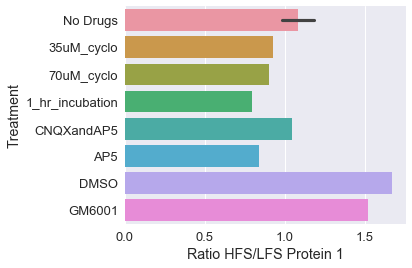

In [116]:
sns.factorplot(kind='bar', x='Ratio HFS/LFS Protein 1', y ='Treatment',data=Experiments_summary_of_HFS_LFS_comp, size=4, aspect=1.5) 

